In [1]:
import os
os.getcwd() 
os.chdir('C:\\Users\\magda\\Documents\\Czechitas\\PYTHON\\Python 2\\lekcie\\dom_ukol_4')

In [2]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image  
import pydotplus
from pydotplus import graph_from_dot_data
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
import matplotlib.pyplot as plt

import os
os.environ["PATH"] += os.pathsep + r'C:\Program Files (x86)\Graphviz\bin'

data = pd.read_csv("ukol_04_data.csv")
data.head()


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [3]:
data.describe()
data.count()

age          49732
job          49732
marital      49732
education    49732
default      49732
balance      49732
housing      49732
loan         49732
contact      49732
day          49732
month        49732
duration     49732
campaign     49732
pdays        49732
previous     49732
poutcome     49732
y            49732
dtype: int64

In [4]:
import numpy as np

y = data["y"]

categorical_columns = ["job", "marital", "education", "default", "housing", "loan", "contact", "campaign", "poutcome"]
numeric_columns = ["age", "balance", "duration", "pdays", "previous"]
numeric_data = data[numeric_columns].to_numpy()

encoder = OneHotEncoder()
encoded_columns = encoder.fit_transform(data[categorical_columns])
encoded_columns = encoded_columns.toarray()

X = np.concatenate([encoded_columns, numeric_data], axis=1)


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Decision Tree

In [6]:
clf = DecisionTreeClassifier(max_depth=4)
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

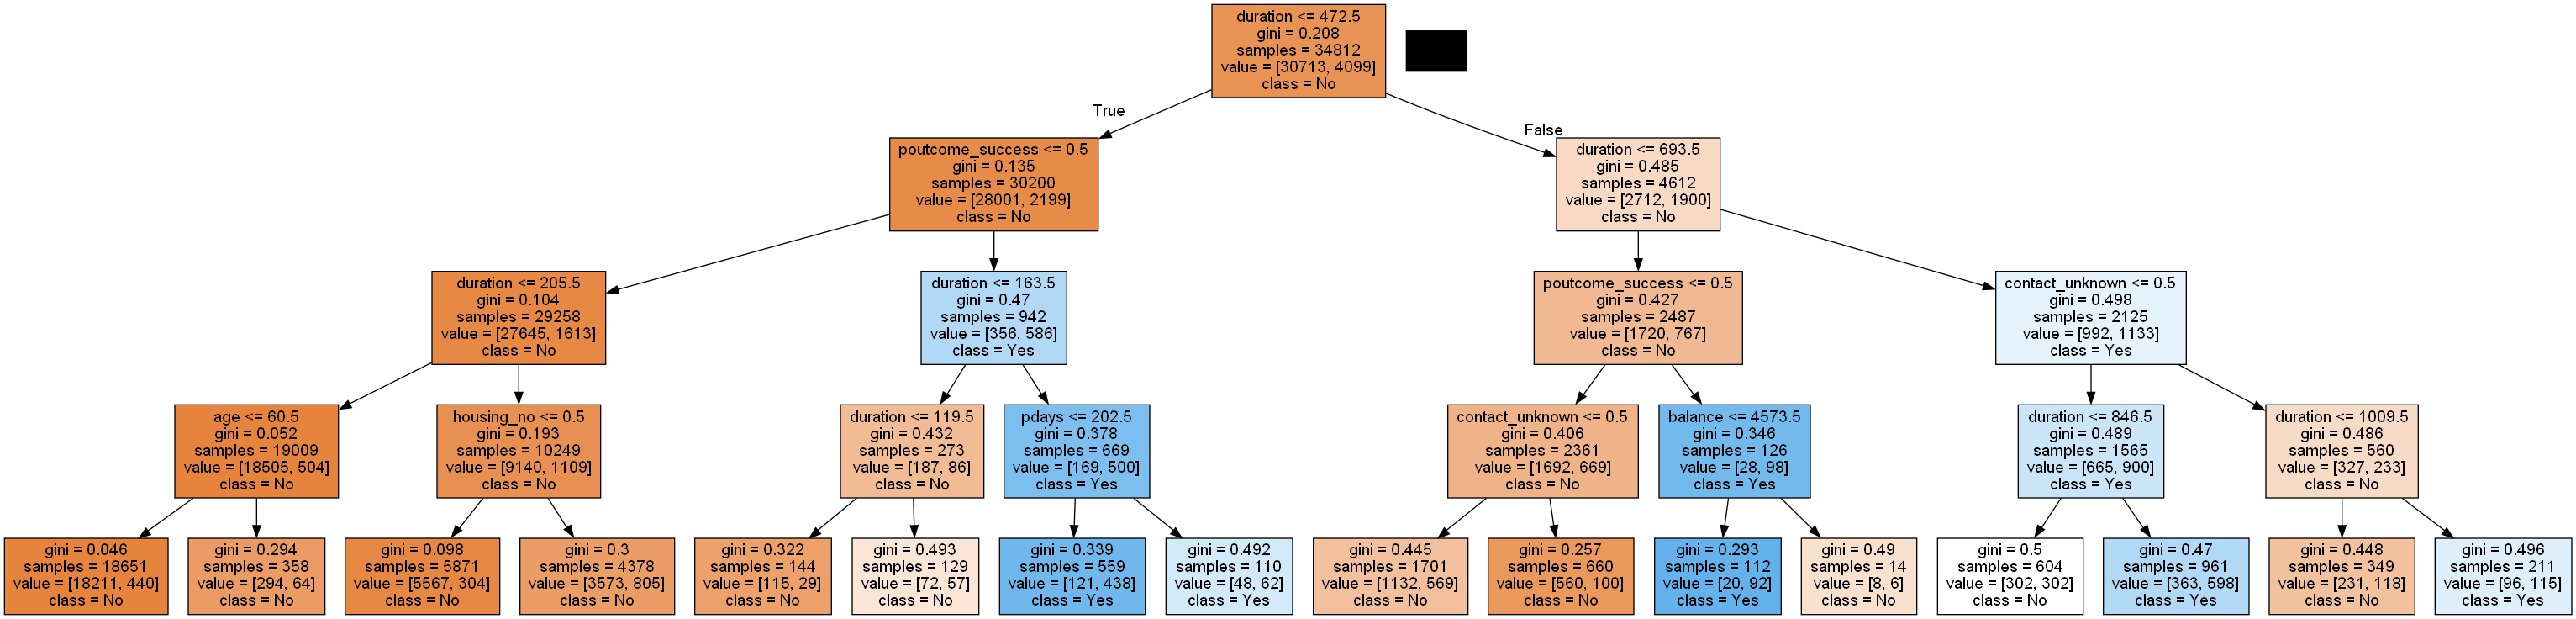

In [7]:
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data, filled=True, feature_names=list(encoder.get_feature_names_out())+numeric_columns, class_names=["No", "Yes"])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

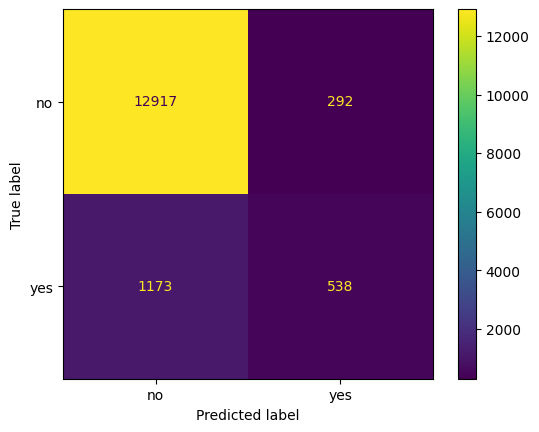

In [8]:
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)

In [9]:
print(accuracy_score(y_test, y_pred))


0.9018096514745308


Podľa https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html, je recall score schopnosť modelu označiť čo najviac,resp. všetky skutočne pozitívne pozorovania, v našom prípade by to bola schopnosť modelu určiť čo najviac osôb, ktoré by mali záujem založiť si (založili by si) v banke termínovaný účet. Recall score: tp/tp+fn

Nižšie vidíme, že z ľudí, ktorí si skutočne termínovaný účet otvorili, označil model iba tretinu ako osoby, ktoré by o termínovaný účet mali záujem. 

In [10]:
print(recall_score(y_test,y_pred,pos_label='yes'))

0.31443600233781416


Vzhľadom k Jirkovým hintom je jasné, že Jirka chcel precision score, ale to ma bez hintu nenapadlo... 

Malo to byť jasné z nasledujúcich dvoch viet v texte?

"Následně ... a nebude kontaktovat ty, u kterých model bude predikovat nezájem. 
Vedení marketingového oddělení se chce vyhnout zbytečnému kontaktování klientů, kteří o termínovaný účet nemají zájem." Pretože recall sa snaží nájsť všetkých, ktorí záujem majú, aj za cenu kontaktovania tých, ktorí skutocný záujem nemajú, ale precision score sa snaží maximalizovať z tých, ktorí sú označení ako tí, čo majú záujem, tých, ktorí ho majú skutočne. Teda, aby tam bolo čo najmenej false positives. Kdežto recall false positives vôbec nezaujímajú, hlavne, aby bolo čo najviac skutočne positives. Proste vedenie nechce otravovať klientov, ktorí by v prípade, že sú zbytočne otravovaní, odišli do inej banky, preto precision. Je to tak správne?

In [11]:
print(precision_score(y_test,y_pred,pos_label='yes'))

0.6481927710843374


In [12]:
depth = list(range(5,13)) 
precision_scores = []
depth

[5, 6, 7, 8, 9, 10, 11, 12]

In [13]:
for d in depth:
    clf = DecisionTreeClassifier(max_depth=d)
    clf = clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    precision_scores.append(precision_score(y_test, y_pred,pos_label='yes')) 


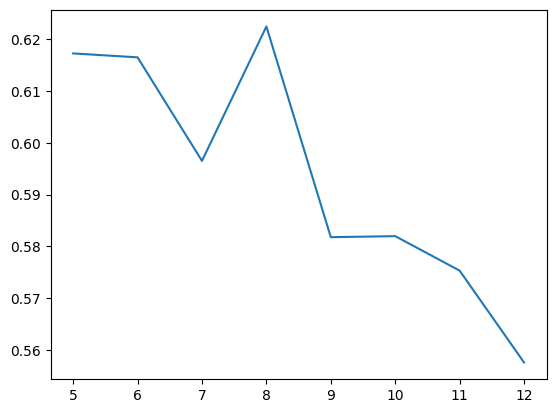

In [14]:
plt.plot(depth, precision_scores)

Vidíme, že ani pri navýšení možnosti hĺbky stromu sa precision score nezlepší oproti hĺbke 4 vrstiev.

### K-nearest neighbours

In [15]:
y = data["y"]

categorical_columns = ["job", "marital", "education", "default", "housing", "loan", "contact", "campaign", "poutcome"]
numeric_columns = ["age", "balance", "duration", "pdays", "previous"]
numeric_data = data[numeric_columns].to_numpy()

scaler = StandardScaler()
numeric_data = scaler.fit_transform(data[numeric_columns])

encoder = OneHotEncoder()
encoded_columns = encoder.fit_transform(data[categorical_columns])
encoded_columns = encoded_columns.toarray()

X = np.concatenate([encoded_columns, numeric_data], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [16]:
clf_KNN = KNeighborsClassifier()
clf_KNN.fit(X_train, y_train)

KNeighborsClassifier()

In [17]:
y_pred = clf_KNN.predict(X_test)

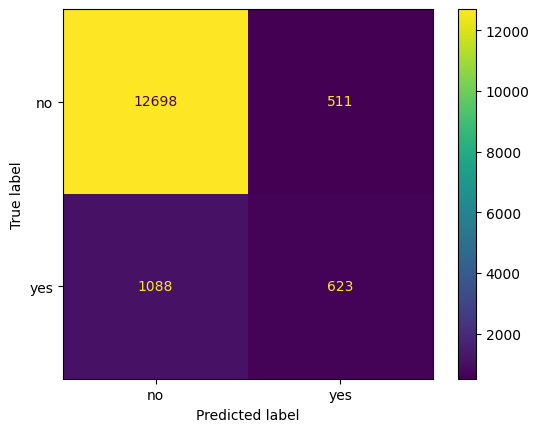

In [18]:
ConfusionMatrixDisplay.from_estimator(
    clf_KNN,
    X_test,
    y_test,
)

In [19]:
print(accuracy_score(y_test, y_pred))

0.892828418230563


In [20]:
print(precision_score(y_test,y_pred,pos_label='yes'))

0.5493827160493827


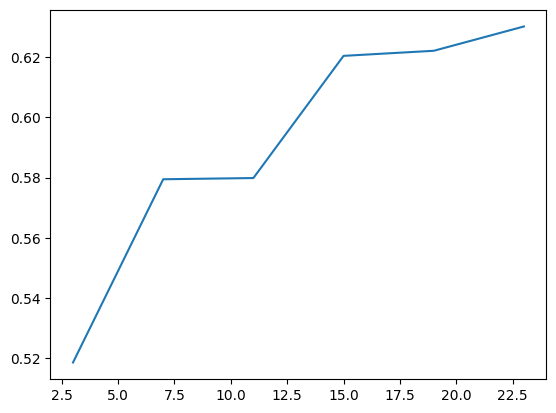

In [21]:
ks = [3,7,11,15,19,23] 
precision_scores = []

for k in ks:
    clf_KNN_search = KNeighborsClassifier(n_neighbors=k)   
    clf_KNN_search.fit(X_train, y_train)
    y_pred = clf_KNN_search.predict(X_test)
    precision_scores.append(precision_score(y_test, y_pred,pos_label='yes')) 
plt.plot(ks, precision_scores)


In [22]:
precision_scores[-1]

0.6301546391752577

Z vyššie uvedeného by človek povedal, že najlepšia hodnota metriky je 23 nearest neighbors, čo sa týka precision scores. u 23 nearest neighbors má hodnotu 0.63 a teda nie je lepšia ako u rozhodovacieho stromu, ktorý má 0.65.

### Support vector machine

In [23]:
y = data["y"]

categorical_columns = ["job", "marital", "education", "default", "housing", "loan", "contact", "campaign", "poutcome"]
numeric_columns = ["age", "balance", "duration", "pdays", "previous"]
numeric_data = data[numeric_columns].to_numpy()

scaler = StandardScaler()
numeric_data = scaler.fit_transform(data[numeric_columns])

encoder = OneHotEncoder()
encoded_columns = encoder.fit_transform(data[categorical_columns])
encoded_columns = encoded_columns.toarray()

X = np.concatenate([encoded_columns, numeric_data], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf_SVM = LinearSVC()
clf_SVM.fit(X_train, y_train)
y_pred = clf_SVM.predict(X_test)

precision_score(y_test, y_pred, pos_label="yes")

c:\Users\magda\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.660904255319149

In [24]:
precision_score(y_test, y_pred, pos_label="yes")

0.660904255319149

Precision score v prípade SVM je 0.66, v prípade K nearest neighbours je to 0.63 a v prípade rozhodovacieho stromu je to 0.65.
V prípade SVM mi to malo vyjsť 0.84, ale nevidím, kde robím chybu...